# Assignment 3

## Instructions
- Run this notebook on ```Google Colab(preferable)```
- Write your code and analysis in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of other cells. 

## Packages Used
- sklearn [link](https://scikit-learn.org/)
- Keras [link](https://keras.io/guides/)

## Submission
- Rename the notebook to `<roll_number>_Assignment3_Q3.ipynb`.


## Question 3
Fake news is a widespread problem and there are many methods for combating it.
You have to build a fake news detection system using a ML model. Train any ML model (ANN, LSTM) over the given Dataset.
The dataset has short statements spoken by people and has the meta-information and corresponding label for those sentences. 
Your target is label column which has 6 labels(in the increasing order of truthfullness): pants-fire, false, barely-true, half-true, mostly-true, true.

The features are 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c', 'venue' and the target is column "label".

The statement is made by speaker whose job, party are given along with 6 columns which are an account of the  type of news(labels) the person has shared before. 
The person who has shared fake content before is likely to share it in future and this can be accounted by the ML model as a feature. Column barely_true_c contains how many barely_true news has the speaker shared (and so is with column X_c, value of X_c is number of X the person shared).


You have to perform two tasks:
* task1: Binary classification <br>
Classify the given news as true/false. Take the labels pants-fire, false, barely-true as false and rest (half-true, mostly-true, true) as true.
* task2: Six-way classification <br>
Classify the given news into six-classes "pants-fire, false, barely-true, half-true, mostly-true, true".

For each of the tasks:
1) Experiment with depth of network and try to fine-tune hyperparameters reporting your observations. <br>
2) Report the accuracy, f1-score, confusion matrix on train, val and test sets. <br>
3) Experiment with bag-of-words, glove and bert embeddings(code given in the below notebook) and report results. <br> Comment on what is the affect of embedding on the results.

The pre-processing code is provided, you need to write the training and test.

Note: You are supposed to train on trainset, fine-tune on val and just eval on test set. If found that you trained on val/test sets, the penalty will be incurred.

In [2]:
#Importing libraries
import numpy as np
import pandas as pd
from tensorflow import keras  #feel free to use any other library
import numpy as np
import seaborn as sns
import re
import tensorflow as tf
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Embedding
from matplotlib import pyplot as plt

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train = pd.read_csv('../input/q3-data/train.csv')
val = pd.read_csv('../input/q3-data/val.csv')
test = pd.read_csv('../input/q3-data/test.csv')

In [4]:
# Dropping the 'id' column
train.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)
val.drop('id', axis = 1, inplace = True)

In [5]:
train.head(5)

,label,statement,subject,speaker,job,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,venue
0,False,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
3,False,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7,19,3,5,44,a news release
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15,9,20,19,2,an interview on CNN


In [6]:
# Checking the shape of data
print(train.shape)
print(val.shape)
print(test.shape)

(10269, 13)
(1284, 13)
(1283, 13)


## Clean and pre-process data
* Replace missing values
* Remove numbers and special characters
* Convert to upper-case

We experiment with two types of processing, one directly appending the other attributes like subject, job, state, party to sentence and then applying bag of words on it.

Other being encoding sentence with glove embeddings and passing just that.

In [7]:

def dataPreprocessing(data):
    '''Function for cleaning the dataset
    '''
    corpus = []
    # Missing values
    data["job"].fillna("no-job", inplace = True)
    data["state"].fillna("no-state", inplace = True)

    for x in range(data.shape[0]):
        statement = re.sub('[^a-zA-Z]', ' ', data['statement'][x]) # Removing all numbers and special characters
        statement = statement.lower() # Converting uppercase to lowercase
        statement = statement.split()
        
        # you can experiment with any other stemmers
        ps = PorterStemmer()
        statement = [ps.stem(word) for word in statement if not word in set(stopwords.words('english'))] # Stemming the dataset and removing stopwords
        statement = ' '.join(statement)
        subject = data['subject'][x].replace(',', ' ')
        speaker = data['speaker'][x]
        job = data['job'][x].lower()
        # job = job.replace(' ', '-')
        state = data['state'][x].lower()
        party = data['party'][x].lower()
        corpus.append(statement + ' '  + subject + ' ' + job + ' ' + state + ' ' + party)
    return corpus

In [8]:
x_train = dataPreprocessing(train)
x_val = dataPreprocessing(val) 
x_test = dataPreprocessing(test) 

In [9]:
len(x_train), len(x_val), len(x_test)

(10269, 1284, 1283)

In [10]:
corpus = x_train + x_val + x_test

## Using bag-of-words embedding


In [48]:
# Converting the corpus into bag-of-words
cv = CountVectorizer(max_features = 8000)
X = cv.fit_transform(corpus).toarray()

In [12]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
X.shape

(12836, 8000)

In [14]:
train.columns

Index(['label', 'statement', 'subject', 'speaker', 'job', 'state', 'party',
       'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c',
       'pants_on_fire_c', 'venue'],
      dtype='object')

In [15]:
# Selecting the columns 'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c'
label_cols = ['barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c',
       'pants_on_fire_c']
x_train2 = train[label_cols]
x_val2 = val[label_cols]
x_test2 = test[label_cols]

In [16]:
print(x_train2.shape)

(10269, 5)


In [17]:
print(X[:len(x_train)].shape)

(10269, 8000)


In [49]:
# Stacking x_train and x_train2 horizontally
x_train_bow = np.hstack((X[:len(x_train)], x_train2))
x_val_bow = np.hstack((X[len(x_train):len(x_train)+len(x_val)], x_val2))
x_test_bow = np.hstack((X[len(x_train)+len(x_val):], x_test2))

In [19]:
x_train_bow.shape

(10269, 8005)

## Use of Glove Embedding


download glove embeddings from 'https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip'
and place in your current working folder


In [ ]:
!unzip "glove.6B.zip" -d "glove"

In [20]:
emmbed_dict = {}
with open('../input/glove-dataset/glove.6B.200d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],'float32')
        emmbed_dict[word]=vector


In [21]:
emmbed_dict['oov'] = np.zeros(200)

In [22]:
!pip3 install sentence_transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

     |████████████████████████████████| 79 kB 981 kB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120748 sha256=1eb7816034476fb0a25f6daf9f184414446074bcfe7ea6dad8287cbe886a0506
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [23]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
def dataPreprocessing_glove(data):
    corpus = []
    # Missing values
    data["job"].fillna("no-job", inplace = True)
    data["state"].fillna("no-state", inplace = True)

    for x in range(data.shape[0]):
        statement = re.sub('[^a-zA-Z]', ' ', data['statement'][x]) # Removing all numbers and special characters
        statement = statement.lower() # Converting uppercase to lowercase
        statement = word_tokenize(statement)

        embed_statement = []
        vec = np.zeros(200)
        cnt = 0
        for w in statement:
            cnt += 1
            if w in emmbed_dict:
                vec += emmbed_dict[w]
            else:
                vec += emmbed_dict['oov']
        
        vec /= cnt
         
        # bonus: Think how you can encode the below features(hint: look upon label encoding or training your own word2vec or any other embedding model)
    
#         subject = data['subject'][x].replace(',', ' ')
#         speaker = data['speaker'][x]
#         job = data['job'][x].lower()
#         # job = job.replace(' ', '-')
#         state = data['state'][x].lower()
#         party = data['party'][x].lower()
        corpus.append(vec)
    
    return np.array(corpus)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
x_train_glove = dataPreprocessing_glove(train)
x_val_glove = dataPreprocessing_glove(val) 
x_test_glove = dataPreprocessing_glove(test) 

In [25]:
x_train_glove = np.hstack((x_train_glove, x_train2))
x_val_glove = np.hstack((x_val_glove, x_val2))
x_test_glove = np.hstack((x_test_glove, x_test2))

## Use of bert embeddings
note: we used our pre-processed code for bow which has the attributed appended to end the end of sentence. 

In [38]:
import torch
import gc

gc.collect()

torch.cuda.empty_cache()

In [39]:
!pip3 install sentence_transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

x_train_bert = np.hstack((model.encode(x_train), x_train2))
x_val_bert = np.hstack((model.encode(x_val), x_val2))
x_test_bert = np.hstack((model.encode(x_test), x_test2))

Batches:   0%|          | 0/321 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Now use the above 3 types of embedded inputs(bow, glove, bert embeddings) for the 2 classification tasks and compare their outputs


# Six-way classification

## Preprocessing

In [50]:
num_classes = 6
# Preprocessing function for the labels
def categorize(data):
    y = data["label"].tolist()

    # Encoding the Dependent Variable
    labelencoder_y = LabelEncoder()
    y = labelencoder_y.fit_transform(y)

    # Converting to binary class matrix
    y = np_utils.to_categorical(y, num_classes)
    return y

In [51]:
y_train_six_way = categorize(train)
y_test_six_way = categorize(test)
y_val_six_way = categorize(val)

Build a model and pass bow, glove and bert embedded inputs: x_train_bow, x_train_glove, x_train_bert(similarly validate for val and report results on test)


### Model

### Using BoW Embeddings

In [52]:
## write your code here
# Initialize hyperparameters
# Create model
# train
# test
# report accuracy, f1-score and confusion matrix
def define_model():
    model = Sequential()
    model.add(Embedding(x_train_bow.shape[1], 100,input_length = x_train_bow.shape[0]))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units = 6))
    return model

In [53]:
model = define_model()
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics='accuracy')

num_of_epochs = 5
model.fit(x_train_bow, y_train_six_way, epochs = num_of_epochs, batch_size = 100, validation_split=0.30)

Epoch 1/5
72/72 [==============================] - 34s 448ms/step - loss: 0.1396 - accuracy: 0.2026 - val_loss: 0.1362 - val_accuracy: 0.2308
Epoch 2/5
72/72 [==============================] - 31s 435ms/step - loss: 0.1356 - accuracy: 0.2339 - val_loss: 0.1351 - val_accuracy: 0.2029
Epoch 3/5
72/72 [==============================] - 31s 430ms/step - loss: 0.1342 - accuracy: 0.2518 - val_loss: 0.1333 - val_accuracy: 0.2132
Epoch 4/5
72/72 [==============================] - 31s 433ms/step - loss: 0.1313 - accuracy: 0.2942 - val_loss: 0.1284 - val_accuracy: 0.3187
Epoch 5/5
72/72 [==============================] - 32s 446ms/step - loss: 0.1252 - accuracy: 0.3422 - val_loss: 0.1227 - val_accuracy: 0.3483


Accuracy on test dataset is:  26.110678911209106
F1 score of the model is:  0.3521051378327432


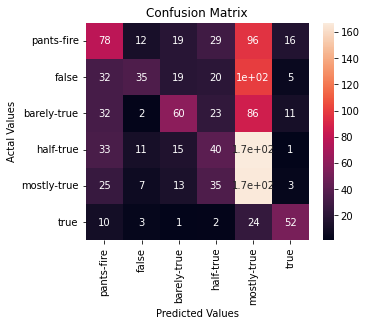

In [54]:
# Accuracy, f1-score, confusion_matrix on test data
layer = tf.keras.layers.Softmax()
temp_y_pred = model.predict(x_test_bow)
output = layer(temp_y_pred).numpy()

y_pred = []
for p in output:
    lst = np.zeros(6,dtype="float32") 
    ind = np.argmax(p, axis=0)
    lst[ind] = 1.0
    y_pred.append(lst)
    
y_pred = np.array(y_pred)

_, acc = model.evaluate(y_pred, y_test_six_way, verbose=0)
print('Accuracy on test dataset is: ',acc * 100.0)

f1_score = metrics.f1_score(y_pred, y_test_six_way, average='weighted')
print('F1 score of the model is: ',f1_score)

cm = confusion_matrix(y_test_six_way.argmax(axis=1), y_pred.argmax(axis=1))

cm_df = pd.DataFrame(cm,
                     index = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true'], 
                     columns = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true'])
from matplotlib import pyplot as plt
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()   

### Using BERT Embeddings

In [43]:
model = define_model()
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics='accuracy')

num_of_epochs = 5
model.fit(x_train_bert, y_train_six_way, epochs = num_of_epochs, batch_size = 100, validation_split=0.30)

Epoch 1/5
72/72 [==============================] - 3s 30ms/step - loss: 0.1393 - accuracy: 0.2028 - val_loss: 0.1355 - val_accuracy: 0.2175
Epoch 2/5
72/72 [==============================] - 2s 26ms/step - loss: 0.1352 - accuracy: 0.2339 - val_loss: 0.1345 - val_accuracy: 0.2158
Epoch 3/5
72/72 [==============================] - 2s 25ms/step - loss: 0.1340 - accuracy: 0.2439 - val_loss: 0.1328 - val_accuracy: 0.2506
Epoch 4/5
72/72 [==============================] - 2s 25ms/step - loss: 0.1307 - accuracy: 0.2949 - val_loss: 0.1280 - val_accuracy: 0.2866
Epoch 5/5
72/72 [==============================] - 2s 25ms/step - loss: 0.1255 - accuracy: 0.3403 - val_loss: 0.1225 - val_accuracy: 0.3496


Accuracy on test dataset is:  25.175368785858154
F1 score of the model is:  0.34003387500897214


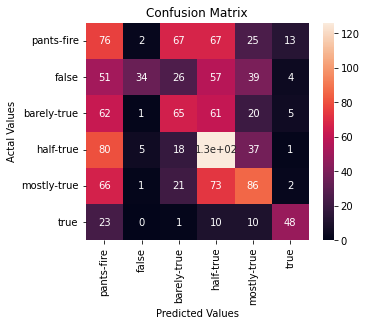

In [44]:
# Accuracy, f1-score, confusion_matrix on test data
layer = tf.keras.layers.Softmax()
temp_y_pred = model.predict(x_test_bert)
output = layer(temp_y_pred).numpy()

y_pred = []
for p in output:
    lst = np.zeros(6,dtype="float32") 
    ind = np.argmax(p, axis=0)
    lst[ind] = 1.0
    y_pred.append(lst)
    
y_pred = np.array(y_pred)

_, acc = model.evaluate(y_pred, y_test_six_way, verbose=0)
print('Accuracy on test dataset is: ',acc * 100.0)

f1_score = metrics.f1_score(y_pred, y_test_six_way, average='weighted')
print('F1 score of the model is: ',f1_score)

cm = confusion_matrix(y_test_six_way.argmax(axis=1), y_pred.argmax(axis=1))

cm_df = pd.DataFrame(cm,
                     index = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true'], 
                     columns = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true'])
from matplotlib import pyplot as plt
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()   

### Using Glove Embeddings

In [30]:
model = define_model()
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics='accuracy')

num_of_epochs = 5
model.fit(x_train_glove, y_train_six_way, epochs = num_of_epochs, batch_size = 100, validation_split=0.30)

2022-04-16 19:32:56.421482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 19:32:56.423016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 19:32:56.424024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 19:32:56.424981: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/5


2022-04-16 19:33:03.586930: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


72/72 [==============================] - 5s 20ms/step - loss: 0.1393 - accuracy: 0.2138 - val_loss: 0.1354 - val_accuracy: 0.2421
Epoch 2/5
72/72 [==============================] - 1s 16ms/step - loss: 0.1356 - accuracy: 0.2323 - val_loss: 0.1344 - val_accuracy: 0.2175
Epoch 3/5
72/72 [==============================] - 1s 15ms/step - loss: 0.1343 - accuracy: 0.2423 - val_loss: 0.1329 - val_accuracy: 0.2324
Epoch 4/5
72/72 [==============================] - 1s 15ms/step - loss: 0.1315 - accuracy: 0.2928 - val_loss: 0.1288 - val_accuracy: 0.3298
Epoch 5/5
72/72 [==============================] - 1s 15ms/step - loss: 0.1263 - accuracy: 0.3415 - val_loss: 0.1230 - val_accuracy: 0.3512


Accuracy on test dataset is:  25.56508183479309
F1 score of the model is:  0.3518615495204969


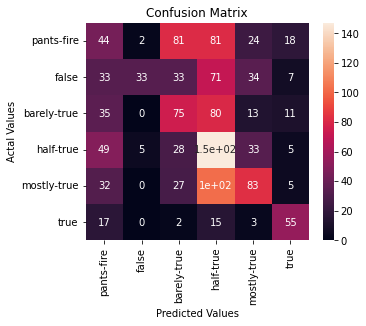

In [31]:
# Accuracy, f1-score, confusion_matrix on test data
layer = tf.keras.layers.Softmax()
temp_y_pred = model.predict(x_test_glove)
output = layer(temp_y_pred).numpy()

y_pred = []
for p in output:
    lst = np.zeros(6,dtype="float32") 
    ind = np.argmax(p, axis=0)
    lst[ind] = 1.0
    y_pred.append(lst)
    
y_pred = np.array(y_pred)

_, acc = model.evaluate(y_pred, y_test_six_way, verbose=0)
print('Accuracy on test dataset is: ',acc * 100.0)

f1_score = metrics.f1_score(y_pred, y_test_six_way, average='weighted')
print('F1 score of the model is: ',f1_score)

cm = confusion_matrix(y_test_six_way.argmax(axis=1), y_pred.argmax(axis=1))

cm_df = pd.DataFrame(cm,
                     index = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true'], 
                     columns = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true'])
from matplotlib import pyplot as plt
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()   

# Binary Classification

## Preprocessing

In [55]:
num_classes = 2

In [56]:
# Function for preprocessing labels
def dataPreprocessingBinary(data):
    y = data["label"].tolist()

    # Changing the 'half-true', 'mostly-true', barely-true', 'pants-fire' labels to True/False for Binary Classification
    for x in range(len(y)):
        if(y[x] == 'half-true'):
            y[x] = 'True'
        elif(y[x] == 'mostly-true'):
            y[x] = 'True'
        elif(y[x] == 'barely-true'):
            y[x] = 'False'
        elif(y[x] == 'pants-fire'):
            y[x] = 'False'

    # Converting the lables into binary class matrix
    labelencoder_y = LabelEncoder()
    y = labelencoder_y.fit_transform(y)
    y = np_utils.to_categorical(y, num_classes)
    return y

In [57]:
y_train_binary = dataPreprocessingBinary(train)
y_test_binary = dataPreprocessingBinary(test)
y_val_binary = dataPreprocessingBinary(val)

## Model
Build a model and pass bow, glove and bert embedded inputs: x_train_bow, x_train_glove, x_train_bert(similarly validate for val and report results on test)


In [58]:
## write your code here
# Initialize hyperparameters
# Create model
# train
# test
# report accuracy, f1-score and confusion matrix
def define_model():
    model = Sequential()
    model.add(Embedding(x_train_bow.shape[1], 100,input_length = x_train_bow.shape[0]))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units = 2))
    return model

### Using BoW Embeddings

In [59]:
model = define_model()
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics='accuracy')

num_of_epochs = 5
model.fit(x_train_bow, y_train_binary, epochs = num_of_epochs, batch_size = 100, validation_split=0.30)

Epoch 1/5
72/72 [==============================] - 33s 443ms/step - loss: 0.2708 - accuracy: 0.5694 - val_loss: 0.2402 - val_accuracy: 0.5881
Epoch 2/5
72/72 [==============================] - 31s 438ms/step - loss: 0.2404 - accuracy: 0.5885 - val_loss: 0.2399 - val_accuracy: 0.5962
Epoch 3/5
72/72 [==============================] - 31s 431ms/step - loss: 0.2381 - accuracy: 0.5936 - val_loss: 0.2350 - val_accuracy: 0.5907
Epoch 4/5
72/72 [==============================] - 31s 428ms/step - loss: 0.2343 - accuracy: 0.6032 - val_loss: 0.2287 - val_accuracy: 0.6173
Epoch 5/5
72/72 [==============================] - 32s 439ms/step - loss: 0.2241 - accuracy: 0.6395 - val_loss: 0.2140 - val_accuracy: 0.6806


Accuracy on test dataset is:  67.0304000377655
F1 score of the model is:  0.6707131912794738


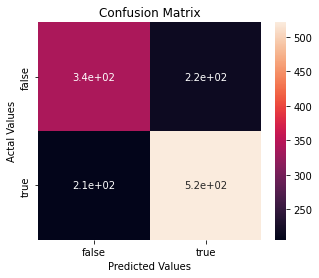

In [60]:
# Accuracy, f1-score, confusion_matrix on test data
layer = tf.keras.layers.Softmax()
temp_y_pred = model.predict(x_test_bow)
output = layer(temp_y_pred).numpy()

y_pred = []
for p in output:
    lst = np.zeros(2,dtype="float32") 
    ind = np.argmax(p, axis=0)
    lst[ind] = 1.0
    y_pred.append(lst)
    
y_pred = np.array(y_pred)

_, acc = model.evaluate(y_pred, y_test_binary, verbose=0)
print('Accuracy on test dataset is: ',acc * 100.0)

f1_score = metrics.f1_score(y_pred, y_test_binary, average='weighted')
print('F1 score of the model is: ',f1_score)

cm = confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1))

cm_df = pd.DataFrame(cm,
                     index = ['false','true'], 
                     columns = ['false', 'true'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()   

### Using BERT Embeddgins

In [46]:
model = define_model()
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics='accuracy')

num_of_epochs = 5
model.fit(x_train_bert, y_train_binary, epochs = num_of_epochs, batch_size = 100, validation_split=0.30)

Epoch 1/5
72/72 [==============================] - 4s 31ms/step - loss: 0.2713 - accuracy: 0.5565 - val_loss: 0.2402 - val_accuracy: 0.5852
Epoch 2/5
72/72 [==============================] - 2s 28ms/step - loss: 0.2411 - accuracy: 0.5900 - val_loss: 0.2377 - val_accuracy: 0.5949
Epoch 3/5
72/72 [==============================] - 2s 25ms/step - loss: 0.2394 - accuracy: 0.5939 - val_loss: 0.2365 - val_accuracy: 0.5940
Epoch 4/5
72/72 [==============================] - 2s 25ms/step - loss: 0.2354 - accuracy: 0.6075 - val_loss: 0.2300 - val_accuracy: 0.6199
Epoch 5/5
72/72 [==============================] - 2s 26ms/step - loss: 0.2264 - accuracy: 0.6294 - val_loss: 0.2134 - val_accuracy: 0.6654


Accuracy on test dataset is:  43.33593249320984
F1 score of the model is:  0.6676875389787743


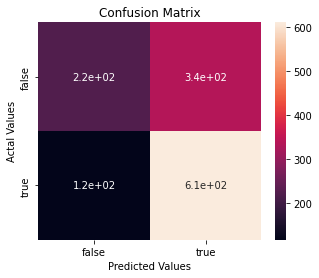

In [47]:
# Accuracy, f1-score, confusion_matrix on test data
layer = tf.keras.layers.Softmax()
temp_y_pred = model.predict(x_test_bert)
output = layer(temp_y_pred).numpy()

y_pred = []
for p in output:
    lst = np.zeros(2,dtype="float32") 
    ind = np.argmax(p, axis=0)
    lst[ind] = 1.0
    y_pred.append(lst)
    
y_pred = np.array(y_pred)

_, acc = model.evaluate(y_pred, y_test_binary, verbose=0)
print('Accuracy on test dataset is: ',acc * 100.0)

f1_score = metrics.f1_score(y_pred, y_test_binary, average='weighted')
print('F1 score of the model is: ',f1_score)

cm = confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1))

cm_df = pd.DataFrame(cm,
                     index = ['false','true'], 
                     columns = ['false', 'true'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()   

### Using Glove Embeddings

In [36]:
model = define_model()
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics='accuracy')

num_of_epochs = 5
model.fit(x_train_glove, y_train_binary, epochs = num_of_epochs, batch_size = 100, validation_split=0.30)

Epoch 1/5
72/72 [==============================] - 3s 20ms/step - loss: 0.2704 - accuracy: 0.5655 - val_loss: 0.2405 - val_accuracy: 0.5865
Epoch 2/5
72/72 [==============================] - 1s 15ms/step - loss: 0.2407 - accuracy: 0.5832 - val_loss: 0.2403 - val_accuracy: 0.5949
Epoch 3/5
72/72 [==============================] - 1s 15ms/step - loss: 0.2393 - accuracy: 0.5871 - val_loss: 0.2345 - val_accuracy: 0.6043
Epoch 4/5
72/72 [==============================] - 1s 15ms/step - loss: 0.2314 - accuracy: 0.6130 - val_loss: 0.2250 - val_accuracy: 0.6209
Epoch 5/5
72/72 [==============================] - 1s 16ms/step - loss: 0.2165 - accuracy: 0.6501 - val_loss: 0.2010 - val_accuracy: 0.6907


Accuracy on test dataset is:  56.66406750679016
F1 score of the model is:  0.6850491780294644


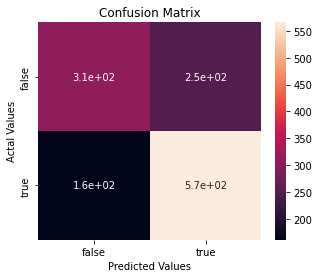

In [37]:
# Accuracy, f1-score, confusion_matrix on test data
layer = tf.keras.layers.Softmax()
temp_y_pred = model.predict(x_test_glove)
output = layer(temp_y_pred).numpy()

y_pred = []
for p in output:
    lst = np.zeros(2,dtype="float32") 
    ind = np.argmax(p, axis=0)
    lst[ind] = 1.0
    y_pred.append(lst)
    
y_pred = np.array(y_pred)

_, acc = model.evaluate(y_pred, y_test_binary, verbose=0)
print('Accuracy on test dataset is: ',acc * 100.0)

f1_score = metrics.f1_score(y_pred, y_test_binary, average='weighted')
print('F1 score of the model is: ',f1_score)

cm = confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1))

cm_df = pd.DataFrame(cm,
                     index = ['false','true'], 
                     columns = ['false', 'true'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()   